In [9]:
# Do necessary imports
import numpy as np
from matplotlib import pyplot as plt

# For the Earth, Sun, Jupiter 3-body Problem:

# Masses of the Planets
Me = 5.972e24                     # Mass of Earth in kg
Ms = 1.989e30                     # Mass of Sun in kg                       
Mj = 500*1.89813e27               # Mass of Jupiter in kg


# Initial Positions of the Planets (vectors)
Re = np.array([1.496e11*1,0,np.sin(0.1265364)*1.496e11*1]) #1 AU away from the sun converted to m
Rs = np.array([0,0,0])
Rj = np.array([1.496e11*5.2,0,np.sin(0.1062906)*1.496e11*5.2]) #5.2 AU away from the sun converted to m

# Initial Velocity of the Planets (vectors)
Ve = np.array([0,30e3*np.cos(0.1265364),30e3*np.sin(0.1265364)])
Vs = np.array([0,0,0])
Vj = np.array([0,13.06e3*np.cos(0.1062906),13.06e3*np.sin(0.1062906)])


u_0 = np.array([Re[0], Re[1], Re[2],
                Rs[0], Rs[1], Rs[2],
                Rj[0], Rj[1], Rj[2],
                Ve[0], Ve[1], Ve[2],
                Vs[0], Vs[1], Vs[2],
                Vj[0], Vj[1], Vj[2]])

G = 6.673e-11                 # Gravitational Constant



# Calculate the gravitional force on a body given the position vectors and the masses of the bodies
# ====================================================================================================================

def Gravitational_Force(ri, rj, mi, mj, G=6.673e-11):
    return ((G*mi*mj*(np.array(rj)-np.array(ri)))/(np.linalg.norm(np.array(rj)-np.array(ri)))**3)

def force(planet, Re, Rs, Rj):
    force_sun_on_earth = Gravitational_Force(Re,Rs,Me,Ms)
    force_earth_on_sun = -force_sun_on_earth
    force_jupiter_on_earth = Gravitational_Force(Re,Rj,Me,Mj)
    force_earth_on_jupiter = -force_jupiter_on_earth
    force_sun_on_jupiter = Gravitational_Force(Rj,Rs,Mj,Ms)
    force_jupiter_on_sun = -force_sun_on_jupiter
    
    if planet == "earth":
        return force_sun_on_earth + force_jupiter_on_earth
    if planet == "sun":
        return force_earth_on_sun + force_jupiter_on_sun
    if planet == "jupiter":
        return force_sun_on_jupiter + force_earth_on_jupiter
    
def acc_planet(planet,Re,Rs,Rj,M):
    a = force(planet, Re, Rs, Rj)/M
    return a
    
def f_true(u):
    Re = [u[0], u[1], u[2]]
    Rs = [u[3], u[4], u[5]]
    Rj = [u[6], u[7], u[8]]

    a_earth = acc_planet('earth',Re,Rs,Rj,Me)
    a_sun = acc_planet('sun',Re,Rs,Rj,Ms)
    a_jupiter = acc_planet('jupiter',Re,Rs,Rj,Mj)
    

    udot = np.array([u[9], u[10], u[11],
                     u[12], u[13], u[14],
                     u[15], u[16], u[17],
                     a_earth[0], a_earth[1], a_earth[2],
                     a_sun[0], a_sun[1], a_sun[2], 
                     a_jupiter[0], a_jupiter[1], a_jupiter[2]])
    
    return udot

# IVP Forward Euler Code
import numpy as np

def ivp_forward_euler(u_0, T, delta_t):
    """Returns the predicted system evolution over time using the forward Euler method.

    This function assumes an f_true(u) function is globally available for calculating the true function value at u.
    
    Parameters
    ----------
    u_0 : array
        1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
    T : float_like
        Final time T
    delta_t : float_like
        Time step size where delta_t = t_{k+1} - t_k
        
    Returns
    -------
    u : array
        K x N array of the predicted states where row k is the state at time step k and K = number of time steps
    times : array_like
        Length K vector containing the times t corresponding to time steps
    """
    

    times = np.arange(0, T+delta_t,delta_t)
    u = np.zeros((len(times),len(u_0)))
    for i in range(len(times)):
        if i == 0:
            u[0] = u_0
        else:  
            u[i] = u[i-1] + delta_t*f_true(u[i-1])
    
    return u, times

In [2]:
def runge_kutta(u_k, delta_t):
    y1 = f_true(u_k)
    y2 = f_true(u_k + (1/2)*delta_t*y1)
    y3 = f_true(u_k + (1/2)*delta_t*y2)
    y4 = f_true(u_k + delta_t*y3)
    u_kplus1 = u_k + (1/6)*delta_t*(y1 + 2*y2 + 2*y3 + y4)
    return u_kplus1

import numpy as np
def ivp_abm3(u_0, T, delta_t):
    """Returns the predicted system evolution over time using the 2-step Adams-Bashforth method.

    This function assumes an f_true(u) function is globally available for calculating the true function value at u.
    
    Parameters
    ----------
    u_0 : array
        1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
    T : float_like
        Final time T
    delta_t : float_like
        Time step size where delta_t = t_{k+1} - t_k
        
    Returns
    -------
    u : array
        K x N array of the predicted states where row k is the state at time step k and K = number of time steps
    times : array_like
        Length K vector containing the times t corresponding to time steps
    """
    
    ### YOUR CODE HERE ###
    times = np.arange(0,T+delta_t,delta_t)
    u = np.zeros((len(times),len(u_0)))
    for i in range(len(times)):
        if i == 0:
            u[0] = u_0
        elif i == 1:
            u[1] = runge_kutta(u[0], delta_t)
        elif i == 2:
            u[2] = runge_kutta(u[1], delta_t)
        else :
            #Adams-Bashforth Predictor
            u[i] = delta_t/12 * (5*f_true(u[i-3]) - 16*f_true(u[i-2]) + 23*f_true(u[i-1])) + u[i-1]
            #Admas-Moulton Corrector
            u[i] = u[i-1] + delta_t/24 * (f_true(u[i-3]) - 5*f_true(u[i-2]) + 19*f_true(u[i-1]) + 9*f_true(u[i]))
    return u, times

def ivp_abm3_error(u_0, T, delta_t):
    """Returns the error in the predicted final system state when using delta_t relative to delta_t_baseline for the 2-step Adams Bashforth method.

    This function assumes an f_true(u) function is globally available for calculating the true function value at u.
    
    Parameters
    ----------
    u_0 : array
        1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
    T : float_like
        Final time T
    delta_t : float_like
        Time step size where delta_t = t_{k+1} - t_k
    delta_t_basleine : float_like
        Baseline time step size where delta_t_baseline = t_{k+1} - t_k
        
    Returns
    -------
    err : float
        Error calculated as ||u_final_delta_t - u_final_delta_t_baseline|| / ||u_final_delta_t_baseline||, where u_final_delta_t is the final predicted state when using delta_t
    """
    
    ### YOUR CODE HERE ###
    u_abm3, times_abm3 = ivp_abm3(u_0, T, delta_t)
    u_t_abm3_final = u_abm3[-1]
    # predict final state using delta_t_baseline
    u, times = analytical(u_0, T, delta_t, ax, ay)
    u_t_analytical_final = u[-1]
    # calculate error
    e = np.linalg.norm(u_t_abm3_final - u_t_analytical_final)/np.linalg.norm(u_t_analytical_final)
    return e

import numpy as np
def ivp_RK4(u_0, T, delta_t):
    """Returns the predicted system evolution over time using the forward Euler method.

    This function assumes an f_true(u) function is globally available for calculating the true function value at u.
    
    Parameters
    ----------
    u_0 : array
        1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
    T : float_like
        Final time T
    delta_t : float_like
        Time step size where delta_t = t_{k+1} - t_k
        
    Returns
    -------
    u : array
        K x N array of the predicted states where row k is the state at time step k and K = number of time steps
    times : array_like
        Length K vector containing the times t corresponding to time steps
    """
    
    ### YOUR CODE HERE ###
    times = np.arange(0,T+delta_t,delta_t)
    u = np.zeros([len(times),len(u_0)])
    for i in range(len(times)):
        if i == 0:
            u[0] = u_0
        else:
            u[i] = runge_kutta(u[i-1], delta_t)
    return u, times

ABM3

In [114]:
# import matplotlib.pyplot as plt
# plt.style.use('default')

# delta_t = 86400
# fig1 = plt.figure(figsize=(16, 16), tight_layout=True)
# ax1 = fig1.add_subplot(221)

# u, times = ivp_abm3(u_0, 3.784e9, 86400)

# # print(u)

# ax1.plot(u[:,0],u[:,1],"dodgerblue", label = "Earth")
# ax1.plot(u[:,3],u[:,4],"orange", label = "Sun")
# ax1.plot(u[:,6],u[:,7],"r", label = "Jupiter")

# ax1.set_title("Trajectory from a Fixed Frame")
# ax1.set_xlabel("$x(m)$")
# ax1.set_ylabel("$y(m)$")
# ax1.legend()

In [115]:
# import matplotlib.pyplot as plt
# plt.style.use('default')

# delta_t = 86400
# fig1 = plt.figure(figsize=(16, 16), tight_layout=True)
# ax1 = fig1.add_subplot(221)

# u, times = ivp_abm3(u_0, 5e8, 86400)

# # print(u)

# ax1.plot(u[:,0],u[:,1],"dodgerblue", label = "Earth")
# ax1.plot(u[:,3],u[:,4],"orange", label = "Sun")
# ax1.plot(u[:,6],u[:,7],"r", label = "Jupiter")

# ax1.set_title("Trajectory from a Fixed Frame")
# ax1.set_xlabel("$x(m)$")
# ax1.set_ylabel("$y(m)$")
# ax1.legend()

In [116]:
# import matplotlib.pyplot as plt
# plt.style.use('default')

# import time
# start = time.time()


# delta_t = 86400
# fig1 = plt.figure(figsize=(16, 16), tight_layout=True)
# ax1 = fig1.add_subplot(221)

# u, times = ivp_abm3(u_0, 3.784e9, 86400)


# ax1.plot(u[:,0]-u[:,3],u[:,1]-u[:,4],"dodgerblue",linestyle = "--", label = "Earth")
# ax1.plot(0,0,'o', color = "orange", label = "Sun")
# ax1.plot(u[:,6]-u[:,3],u[:,7]-u[:,4],"r", label = "Jupiter")

# innercircle = plt.Circle((0,0), radius = 1.496e11*0.9, fill = False, color = "pink")
# outercircle = plt.Circle((0,0), radius = 1.496e11*1.2, fill = False, color = "pink")
# ax1.add_patch(innercircle)
# ax1.add_patch(outercircle)

# ax1.set_title("Orbit Trajectories in the Rotating Frame about the Sun")
# ax1.set_xlabel("$x(m)$")
# ax1.set_ylabel("$y(m)$")
# ax1.legend()

# end = time.time()
# print(end - start)

RK4

In [10]:
u, times = ivp_RK4(u_0, 3.784e9, 86400)

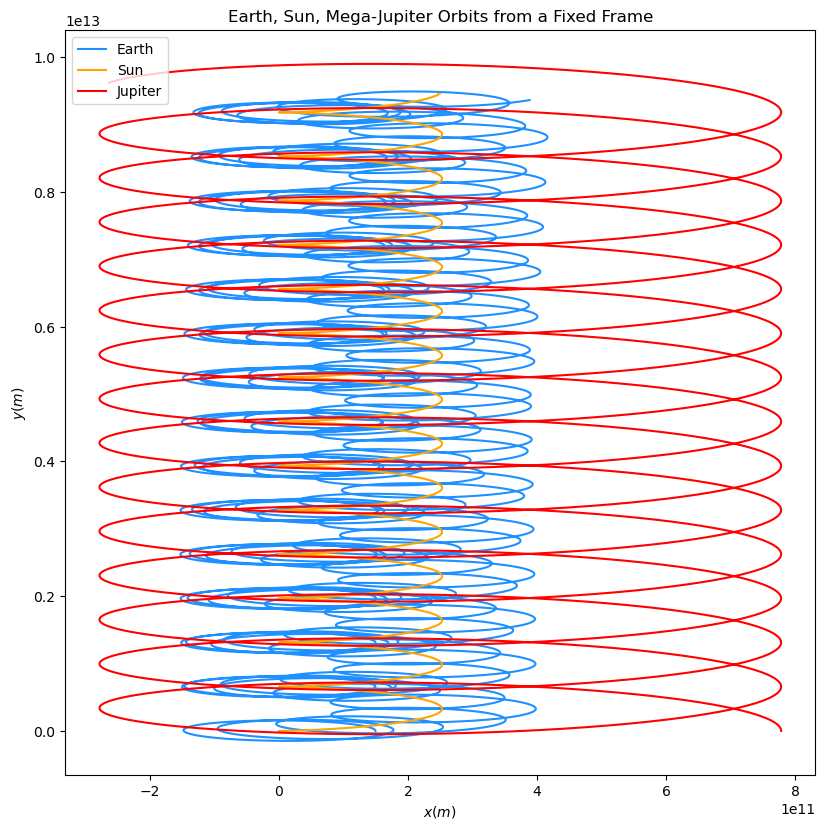

In [4]:
import matplotlib.pyplot as plt
plt.style.use('default')

fig1 = plt.figure(figsize=(16, 16), tight_layout=True)
ax1 = fig1.add_subplot(221)


ax1.plot(u[:,0],u[:,1],"dodgerblue", label = "Earth")
ax1.plot(u[:,3],u[:,4],"orange", label = "Sun")
ax1.plot(u[:,6],u[:,7],"r", label = "Jupiter")

ax1.set_title("Earth, Sun, Mega-Jupiter Orbits from a Fixed Frame")
ax1.set_xlabel("$x(m)$")
ax1.set_ylabel("$y(m)$")
ax1.legend()

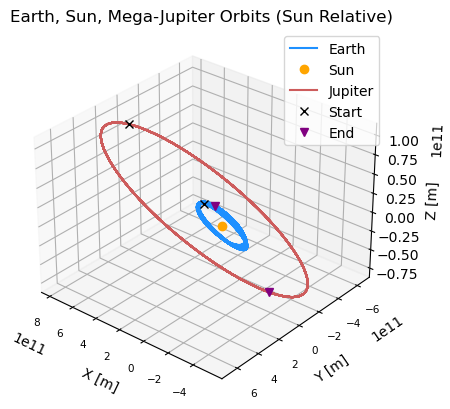

In [5]:
# MAKE IT 3D 

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot3D(u[:,0]-u[:,3],u[:,1]-u[:,4], u[:,2]-u[:,5], "dodgerblue", label = "Earth")
ax.plot3D(0,0,0,'o',color="orange", label = "Sun")
ax.plot3D(u[:,6]-u[:,3],u[:,7]-u[:,4], u[:,8]-u[:,5],"indianred", label = "Jupiter")
ax.view_init(elev = 30, azim=130)
ax.set_xlabel('X [m]', fontsize=10)
plt.xticks(fontsize=7.5)
ax.set_ylabel('Y [m]', fontsize=10)
plt.yticks(fontsize=7.5)
ax.set_zlabel('Z [m]', fontsize=10, rotation = 90)
ax.set_title("Earth, Sun, Mega-Jupiter Orbits (Sun Relative)")

ax.plot3D(u[0][0]-u[0][3], u[0][1]-u[0][4],u[0][2]-u[0][5],'x', color = "black", label = "Start")
ax.plot3D(u[0][6]-u[0][3], u[0][7]-u[0][4], u[0][8]-u[0][5],'x', color = "black")

ax.plot3D(u[-1][0]-u[-1][3], u[-1][1]-u[-1][4],u[-1][2]-u[-1][5],'v', color = "purple", label = "End")
ax.plot3D(u[-1][6]-u[-1][3], u[-1][7]-u[-1][4],u[-1][8]-u[-1][5],'v', color = "purple")

plt.legend()
plt.show()

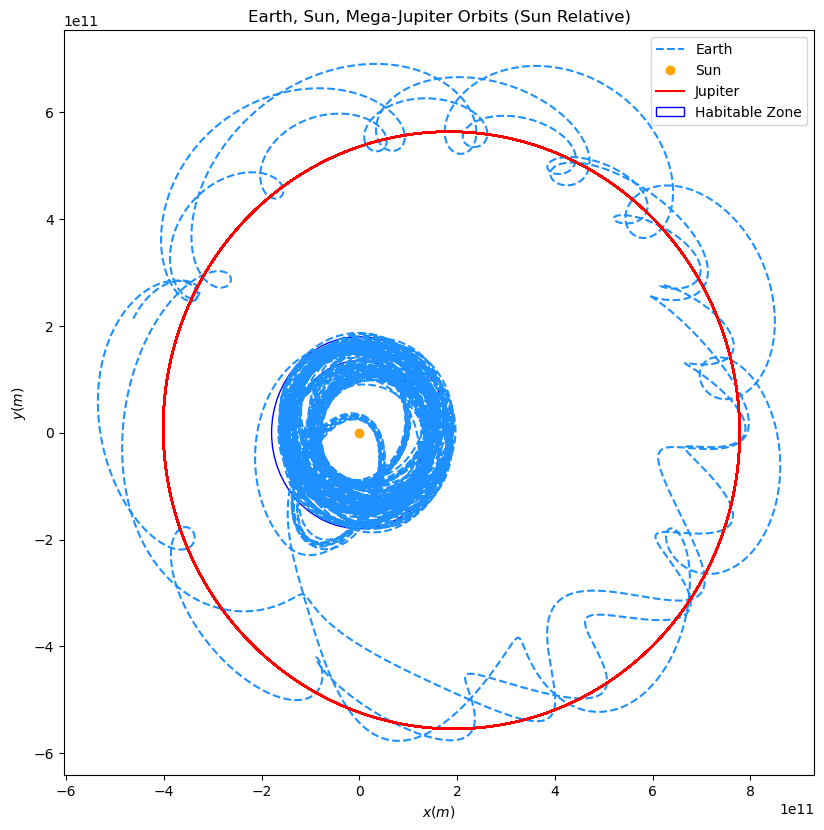

In [13]:
import matplotlib.pyplot as plt
plt.style.use('default')

fig1 = plt.figure(figsize=(16, 16), tight_layout=True)
ax1 = fig1.add_subplot(221)


ax1.plot(u[:,0]-u[:,3],u[:,1]-u[:,4],"dodgerblue",linestyle = "--", label = "Earth")
ax1.plot(0,0,'o', color = "orange", label = "Sun")
ax1.plot(u[:,6]-u[:,3],u[:,7]-u[:,4],"r", label = "Jupiter")

innercircle = plt.Circle((0,0), radius = 1.496e11*0.9, fill = False, color = "blue", label = "Habitable Zone")
outercircle = plt.Circle((0,0), radius = 1.496e11*1.2, fill = False, color = "blue")
ax1.add_patch(innercircle)
ax1.add_patch(outercircle)

ax1.set_title("Earth, Sun, Mega-Jupiter Orbits with 500 times the Mass of (Sun Relative)")
ax1.set_xlabel("$x(m)$")
ax1.set_ylabel("$y(m)$")
ax1.legend()

In [11]:
outer_habitable_zone = 1.496e11*1.2 #m
inner_habitable_zone = 1.496e11*0.9 #m

out_of_zone = []

for k,pos in enumerate(u):
    Re = np.array([pos[0], pos[1], pos[2]])
    Rs = np.array([pos[3], pos[4], pos[5]])
    if np.linalg.norm(Re-Rs) > outer_habitable_zone:
        print("Too far from the sun")
        out_of_zone.append(times[k])
    if np.linalg.norm(Re-Rs) < inner_habitable_zone:
        print("Too close to the sun")
        out_of_zone.append(times[k])
    else:
        pass
if len(out_of_zone) == 0:
    print("We are inside the habitable zone")

Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to 

Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to 

Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too close to 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too close to the sun
Too close to the sun
Too close to 

Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too close to the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from 

Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from the sun
Too far from 

In [12]:
out_of_zone


[93225600.0,
 93312000.0,
 93398400.0,
 93484800.0,
 93571200.0,
 93657600.0,
 93744000.0,
 93830400.0,
 93916800.0,
 94003200.0,
 94089600.0,
 94176000.0,
 94262400.0,
 94348800.0,
 94435200.0,
 94521600.0,
 94608000.0,
 94694400.0,
 94780800.0,
 94867200.0,
 94953600.0,
 95040000.0,
 95126400.0,
 95212800.0,
 95299200.0,
 95385600.0,
 95472000.0,
 95558400.0,
 95644800.0,
 95731200.0,
 95817600.0,
 95904000.0,
 95990400.0,
 96076800.0,
 96163200.0,
 96249600.0,
 96336000.0,
 96422400.0,
 96508800.0,
 96595200.0,
 96681600.0,
 117072000.0,
 117158400.0,
 117244800.0,
 117331200.0,
 117417600.0,
 117504000.0,
 117590400.0,
 117676800.0,
 117763200.0,
 117849600.0,
 117936000.0,
 118022400.0,
 118108800.0,
 118195200.0,
 118281600.0,
 118368000.0,
 118454400.0,
 118540800.0,
 118627200.0,
 118713600.0,
 118800000.0,
 118886400.0,
 118972800.0,
 119059200.0,
 119145600.0,
 119232000.0,
 119318400.0,
 119404800.0,
 119491200.0,
 119577600.0,
 119664000.0,
 119750400.0,
 119836800.0,
 1199

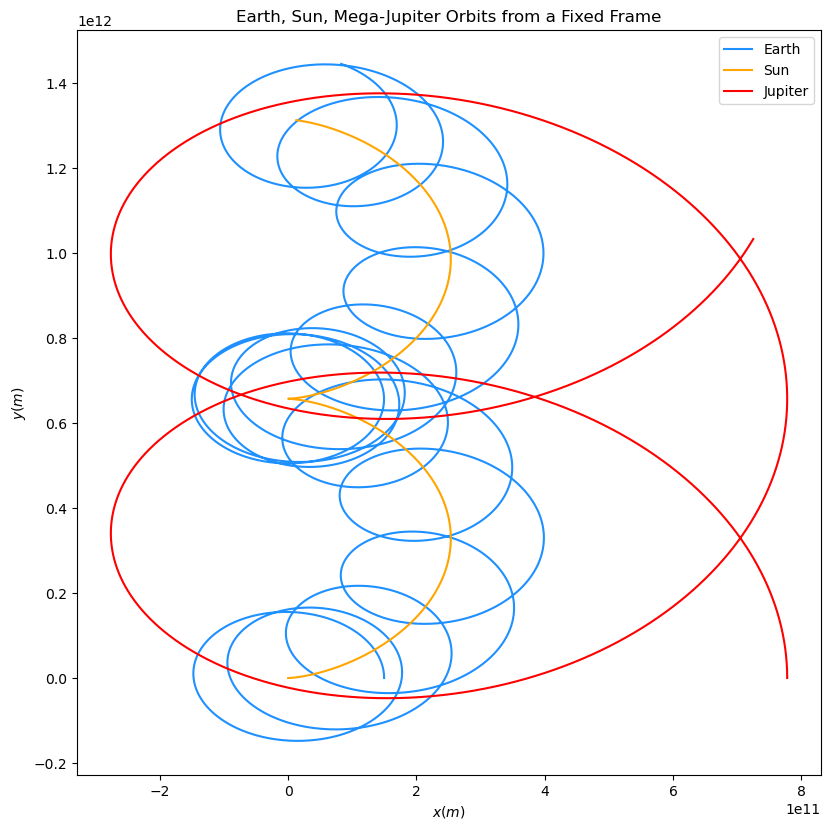

In [163]:
import matplotlib.pyplot as plt
plt.style.use('default')

u, times = ivp_RK4(u_0, 5e8, 86400)
delta_t = 86400
fig1 = plt.figure(figsize=(16, 16), tight_layout=True)
ax1 = fig1.add_subplot(221)

ax1.plot(u[:,0],u[:,1],"dodgerblue", label = "Earth")
ax1.plot(u[:,3],u[:,4],"orange", label = "Sun")
ax1.plot(u[:,6],u[:,7],"r", label = "Jupiter")

ax1.set_title("Earth, Sun, Mega-Jupiter Orbits from a Fixed Frame")
ax1.set_xlabel("$x(m)$")
ax1.set_ylabel("$y(m)$")
ax1.legend()